# Imports

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from typing import Optional, Tuple, Union, Sequence, Dict
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

# User Configuration

In [2]:
SAVE_DATA = True

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

SAMPLING_SIZE = None # Set None to use all data
RANDOM_SEED = 42

DATA_DIR = Path("../../data")
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists
OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="talk",
    palette="colorblind"
)

# Utility Functions

In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

In [4]:
def prepare_data(df_real, df_synth, negative_control=False):
    df_real = df_real.copy()
    df_synth = df_synth.copy()
    df_combined = pd.concat([df_real, df_synth], ignore_index=True).reset_index(drop=True)

    if negative_control:
        df_combined['label'] = np.random.randint(0, 2, size=len(df_combined))
    else:
        df_combined.loc[:len(df_real)-1, 'label'] = 1
        df_combined.loc[len(df_real):,   'label'] = 0

    rng = np.random.default_rng(RANDOM_SEED)
    idx = rng.choice(df_combined.index,    size=len(df_real), replace=True)
    df_combined = df_combined.loc[idx].reset_index(drop=True)

    return df_combined

# Main Routine

In [5]:
df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)


## Unique Kategorien für Encoder

In [6]:
df = prepare_data(df_real, df_synth)
print(df.dtypes)

num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols.remove('label')

cat_cols = df.select_dtypes(include=['category', 'bool']).columns.drop(
    ['consciousness_level','news_score']
).tolist()
ord_cols = ['consciousness_level','news_score']

icu_admission_24h          bool
age                       Int64
gender                 category
ethnicity              category
consciousness_level    category
temperature             float64
heart_rate                Int64
respiratory_rate          Int64
oxygen_saturation         Int64
systolic_bp               Int64
diastolic_bp              Int64
news_score             category
night_arrival              bool
weekend_arrival            bool
chief_complaint        category
icd_block              category
label                   float64
dtype: object


In [7]:
cat_categories = {
    col: sorted(df[col].dropna().unique().tolist())
    for col in cat_cols
}
ord_categories = {
    col: sorted(df[col].dropna().unique().tolist())
    for col in ord_cols
}

## (Optional) Sampling

In [8]:
if SAMPLING_SIZE is not None:
    rng = np.random.default_rng(RANDOM_SEED)
    idx_real    = rng.choice(df_real.index,    size=SAMPLING_SIZE, replace=True)
    idx_synth   = rng.choice(df_synth.index,   size=SAMPLING_SIZE, replace=True)
    idx_holdout = rng.choice(df_holdout.index, size=SAMPLING_SIZE, replace=True)
    idx_combined = rng.choice(df.index, size=SAMPLING_SIZE, replace=True)

    df_real    = df_real.loc[idx_real].reset_index(drop=True)
    df_synth   = df_synth.loc[idx_synth].reset_index(drop=True)
    df_holdout = df_holdout.loc[idx_holdout].reset_index(drop=True)
    df_combined = df.loc[idx_combined].reset_index(drop=True)

## Positiv-/Negativ-Kontrolle

In [9]:
# Negative Kontrolle (identische Datensätze)
df_negative_control = df_real.copy()
df_neg = prepare_data(df_real, df_negative_control, negative_control=True)

# Positive Kontrolle (stark manipulierte synthetische Daten)
df_positive_control = df_real.copy()
df_positive_control["age"] += np.random.normal(50, 10, size=len(df_positive_control)).round(0).astype(int)
df_positive_control["temperature"] += np.random.normal(6, 2, size=len(df_positive_control)).round(1)
df_pos = prepare_data(df_real, df_positive_control, negative_control=False)

# ML Logic
## Preprocessing: Features & Ziel trennen, Transformer bauen

In [10]:
def prepare_features(df, target: str='label'):
    """
    Gibt (preprocessor, X, y) zurück.
    Encoder: numerisch → StandardScaler,
             kategorial → OneHotEncoder(ignore_unknowns),
             ordinal → OrdinalEncoder.
    """
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

    df = df.copy()
    y = df[target]
    X = df.drop(columns=[target])

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(
                categories=[cat_categories[c] for c in cat_cols],
                handle_unknown='ignore',
                sparse_output=False
            ),
        cat_cols),
        ('ord', OrdinalEncoder(
                categories=[ord_categories[c] for c in ord_cols],
                handle_unknown='use_encoded_value',
                unknown_value=-1
            ),
        ord_cols)
    ], remainder="drop")

    return preprocessor, X, y

## Modelle definieren

In [11]:
def define_models(rng_seed=RANDOM_SEED):
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier

    return {
        'Logistic Regression': LogisticRegression(max_iter=500, random_state=rng_seed),
        'KNN'                : KNeighborsClassifier(n_neighbors=5),
        'Random Forest'      : RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=rng_seed,
            n_jobs=-1)
    }

## 2.2 Processor, Models

## 2.3 Funktion

In [12]:
def _get_timestamp() -> str:
    """YYYYMMDD_HHMMSS für Dateinamen."""
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _ensure_dir(path: Path) -> None:
    """Erstellt Ordner rekursiv, falls nötig."""
    path.mkdir(parents=True, exist_ok=True)


def _validate_model_names(
    available: Sequence[str],
    selected: Sequence[str]
) -> None:
    """Fehlermeldung, wenn ein Modellname ungültig ist."""
    missing = set(selected) - set(available)
    if missing:
        raise ValueError(f"Unbekannte Modelle: {missing}")


def _compute_pmse(prop: np.ndarray) -> float:
    """pMSE = Varianz um den Mittelwert."""
    mu = prop.mean()
    return float(np.mean((prop - mu) ** 2))


def _slice_Xy(
    X: Union[pd.DataFrame, np.ndarray],
    y: Union[pd.Series, np.ndarray],
    idx: np.ndarray
) -> Tuple:
    """Zieht per Index-Array X.iloc bzw. X[...] plus y[...] heraus."""
    if isinstance(X, pd.DataFrame):
        return X.iloc[idx], y.iloc[idx]
    return X[idx], y[idx]


def _compute_oof(
    preprocessor,
    model,
    X: Union[pd.DataFrame, np.ndarray],
    y: Union[pd.Series, np.ndarray],
    cv: int,
    random_state: int
) -> Tuple[np.ndarray, Sequence[float]]:
    """
    Liefert:
      - out-of-fold Propensity-Score Array (ganze Länge von y)
      - Liste der pMSE je Fold
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    prop_oof = np.zeros(len(y))
    fold_scores: list[float] = []

    for train_idx, test_idx in skf.split(X, y):
        X_tr, y_tr = _slice_Xy(X, y, train_idx)
        X_te, y_te = _slice_Xy(X, y, test_idx)

        pipe = Pipeline([('pre', preprocessor), ('clf', model)])
        pipe.fit(X_tr, y_tr)
        proba = pipe.predict_proba(X_te)[:, 1]

        prop_oof[test_idx] = proba
        fold_scores.append(np.mean((proba - proba.mean()) ** 2))

    return prop_oof, fold_scores


def _plot_hist(
    prop: np.ndarray,
    y: Union[pd.Series, np.ndarray],
    title: str,
    pmse: float,
    labels: Tuple[str, str],
    bins: int,
    figsize: Tuple[int, int]
) -> plt.Figure:
    """Allgemeines Histogramm plotten, mit Mean-Linie + Legende."""
    palette_cb = sns.color_palette("colorblind", 2)
    color_real, color_synth = palette_cb[0], palette_cb[1]

    fig, ax = plt.subplots(figsize=figsize)
    ax.hist(prop[y == 1], bins=bins, alpha=0.8, label=f'{labels[0]} (1)', color=color_real)
    ax.hist(prop[y == 0], bins=bins, alpha=0.8, label=f'{labels[1]} (0)', color=color_synth)
    ax.axvline(prop.mean(), color='k', ls='--',
               label=f'μ = {prop.mean():.2f}')
    ax.set_title(f'{title}\n pMSE = {pmse:.5f}')
    ax.set_xlabel('Propensity-Score (P[real])')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, 1)
    xt = [i/10 for i in range(11)]
    ax.set_xticks(xt)
    ax.set_xticklabels([f'{v:.1f}' if i%2==0 else '' for i,v in enumerate(xt)])
    ax.legend(
        loc='upper left',
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0
    )
    fig.tight_layout()
    return fig


def pmse_final(
    df: pd.DataFrame,
    model_names: Optional[Sequence[str]] = None,
    bins: int = 25,
    labels: Tuple[str, str] = ('Real', 'Synthetic'),
    save_figures: bool = False,
    figures_dir: Union[str, Path] = Path('figures'),
    figsize: Tuple[int, int] = (6, 4),
    cv: int = 1,
    random_state: int = 42,
    return_figs: bool = False
) -> Union[pd.DataFrame, Tuple[pd.DataFrame, Dict[str, plt.Figure]]]:
    """
    pMSE-Berechnung mit optionaler Stratified K-Fold CV.

    Parameters
    ----------
    df : DataFrame mit Spalte 'label'
    model_names : Liste der Namen aus define_models(); default = alle.
    bins : Anzahl der Bins im Histogramm.
    labels : Tuple Beschriftungen für Klasse 1 und 0.
    save_figures : TIFFs speichern?
    figures_dir : Ordner für die TIFFs.
    figsize : Figure-Größe.
    cv : int, Folds; wenn <=1 → keine CV (Whole-sample), sonst CV.
    random_state : Reproducibility für StratifiedKFold.
    return_figs : zusätzlich Dict von Figures zurückgeben.

    Returns
    -------
    DataFrame mit Index=Model und Spalten:
      - bei cv<=1: ['pMSE']
      - bei cv>1: ['pMSE_overall','fold_1',…,'fold_{cv}']
    (Optional, Figures-Dict)
    """
    ts = _get_timestamp()
    figures_dir = Path(figures_dir)
    if save_figures:
        _ensure_dir(figures_dir)

    preprocessor, X, y = prepare_features(df, target='label')
    all_models = define_models()
    if model_names is None:
        model_names = list(all_models.keys())
    else:
        _validate_model_names(all_models.keys(), model_names)

    records: list[dict] = []
    figs: Dict[str, plt.Figure] = {}

    for name in model_names:
        model = all_models[name]

        if cv > 1:
            prop, fold_scores = _compute_oof(
                preprocessor, model, X, y, cv, random_state
            )
            overall = _compute_pmse(prop)
            # Record
            rec = {'Model': name, 'pMSE_overall': overall}
            rec.update({f'fold_{i+1}': s for i, s in enumerate(fold_scores)})
            title = name + " (CV)"
            pmse_val = overall

        else:
            pipe = Pipeline([('pre', preprocessor),
                             ('clf', model)])
            pipe.fit(X, y)
            prop = pipe.predict_proba(X)[:, 1]
            pmse_val = _compute_pmse(prop)
            rec = {'Model': name, 'pMSE': pmse_val}
            title = name

        records.append(rec)

        # Plot
        fig = _plot_hist(title=title,
                         prop=prop,
                         y=y,
                         pmse=pmse_val,
                         labels=labels,
                         bins=bins,
                         figsize=figsize)

        if save_figures:
            fname = f'ClassDiff_{name.replace(" ", "")}_{ts}.tiff'
            fig.savefig(
                figures_dir / fname,
                dpi=300, format='tiff',
                bbox_inches='tight',
                pil_kwargs={'compression': 'tiff_lzw'}
            )

        figs[name] = fig
        plt.show()

    df_res = pd.DataFrame(records).set_index('Model')
    if return_figs:
        return df_res, figs
    return df_res

# 3. Anwendung
## 3.1 Proof-of-Concept-Test (POC-Test)
### 3.1.1 Negativ Control

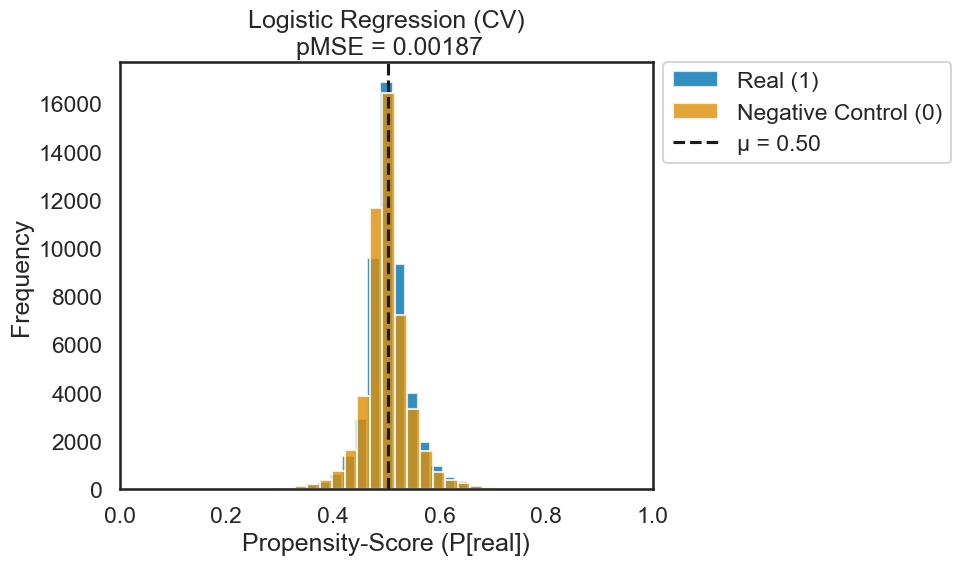

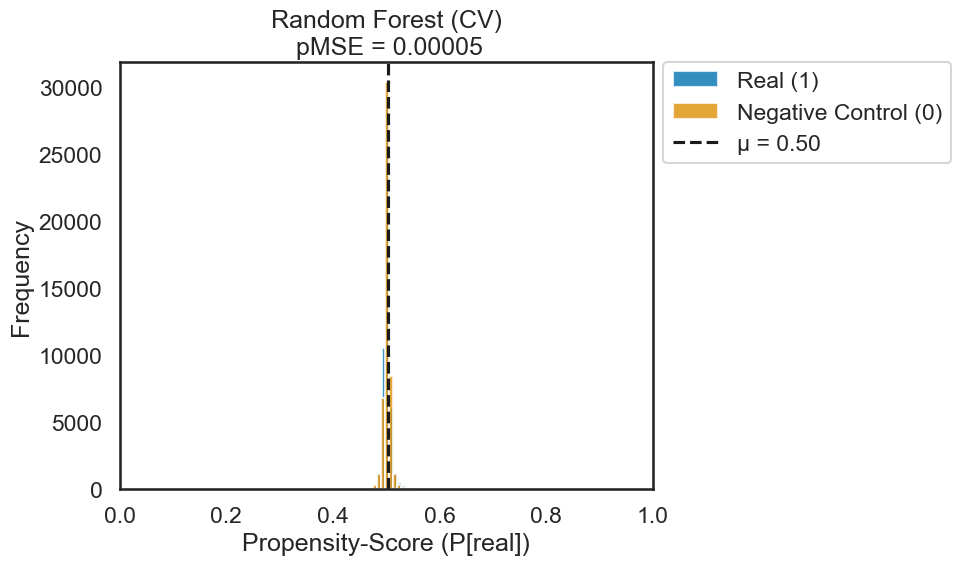

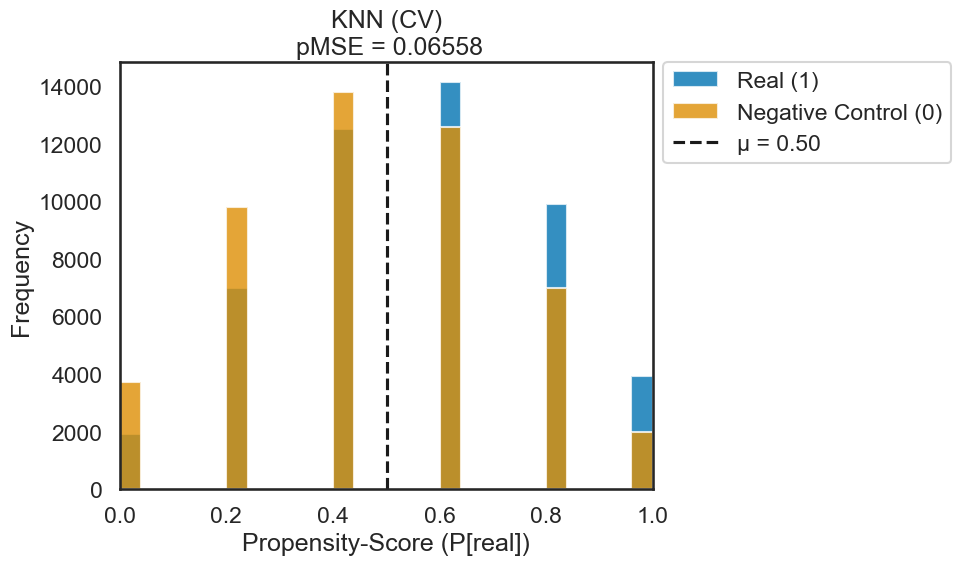

,pMSE_overall,fold_1,fold_2,fold_3,fold_4,fold_5
Model,,,,,,
Logistic Regression,0.001866,0.001923,0.001758,0.001853,0.001879,0.001913
Random Forest,0.000048,0.000045,0.000050,0.000047,0.000052,0.000047
KNN,0.065584,0.065588,0.066696,0.064889,0.064929,0.065767


In [ ]:
# Laufzeit des vollen Datasets: 2 m
summary = pmse_final(df_neg, labels=['Real', 'Negative Control'], cv=5, save_figures=SAVE_DATA, figsize = (10, 6),
                          model_names=['Logistic Regression', 'Random Forest', 'KNN'])

display(summary)

if SAVE_DATA:
    current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    summary.to_csv(
        f'results/pmse_negative-ctrl_{current_timestamp}.csv',
        index=True, sep=';', decimal=',', encoding='utf-8'
    )

### 3.1.2 Positiv Kontrolle

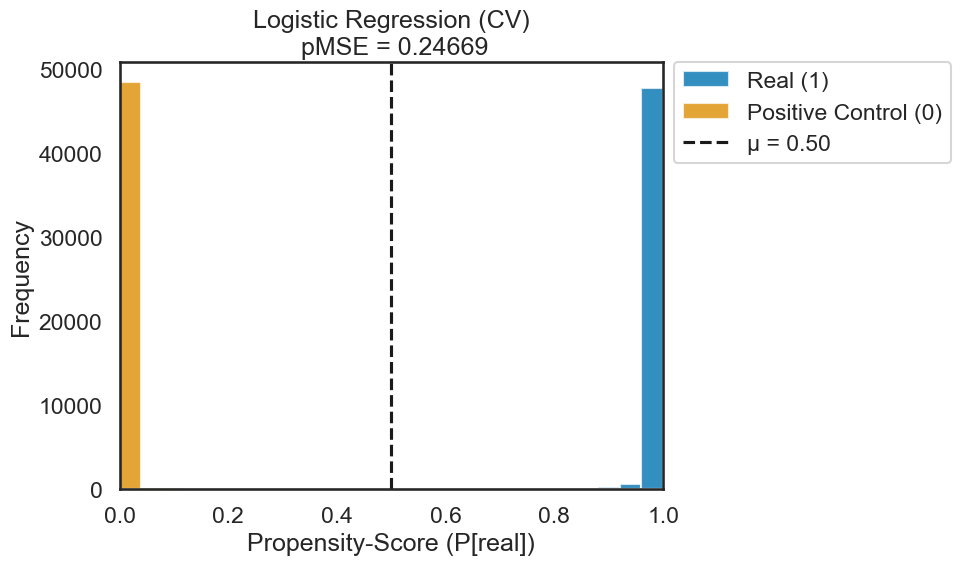

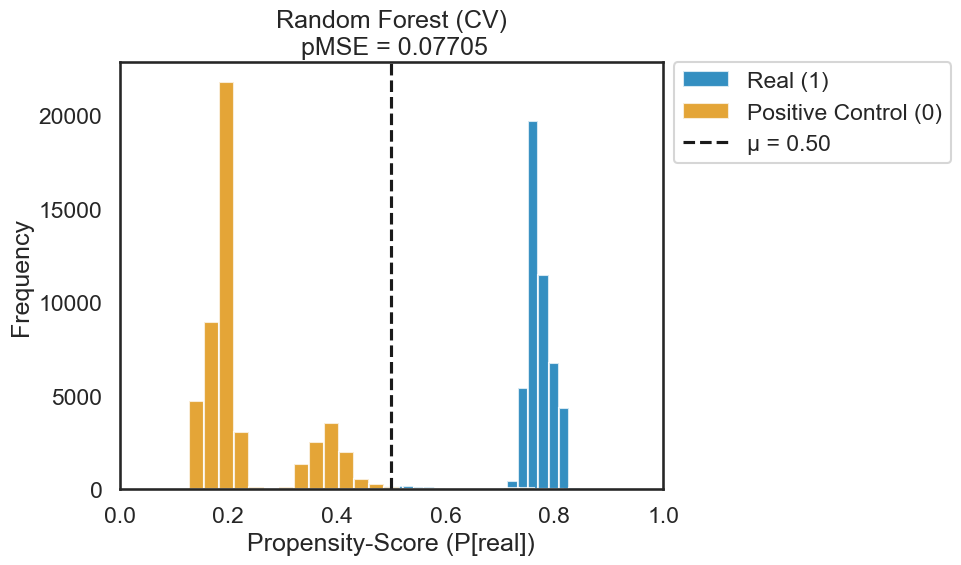

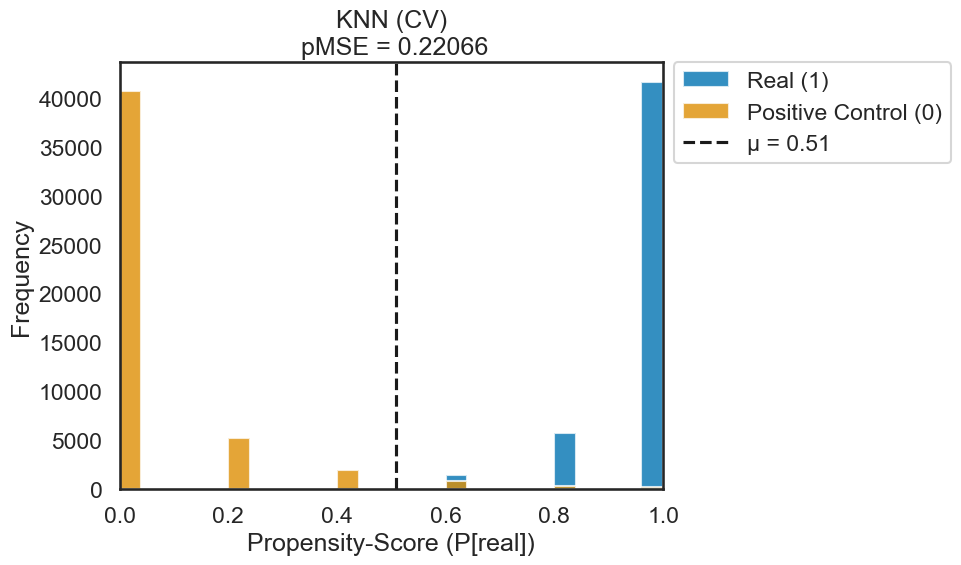

,pMSE_overall,fold_1,fold_2,fold_3,fold_4,fold_5
Model,,,,,,
Logistic Regression,0.246693,0.246885,0.246736,0.246687,0.246591,0.246568
Random Forest,0.077051,0.071489,0.094920,0.066944,0.071422,0.080481
KNN,0.220662,0.220137,0.221054,0.220516,0.220888,0.220710


In [ ]:
# Laufzeit des vollen Datasets: 1,5 m
summary = pmse_final(df_pos, labels=['Real', 'Positive Control'], cv=5, save_figures=SAVE_DATA, figsize = (10, 6),
                          model_names=['Logistic Regression', 'Random Forest', 'KNN'])

display(summary)

if SAVE_DATA:
    current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    summary.to_csv(
        f'results/pmse_positive-ctrl_{current_timestamp}.csv',
        index=True, sep=';', decimal=',', encoding='utf-8'
    )

## 3.2 Finale Analyse

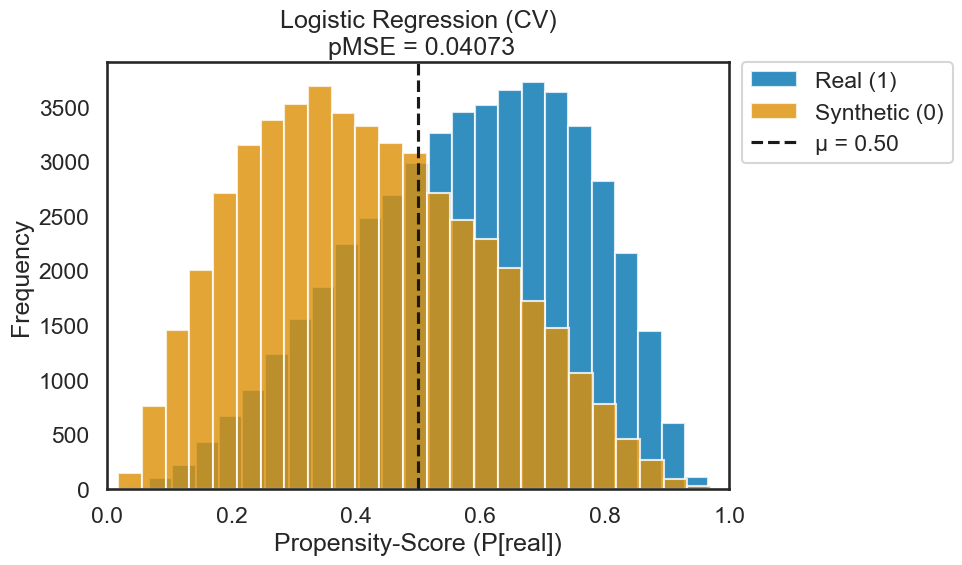

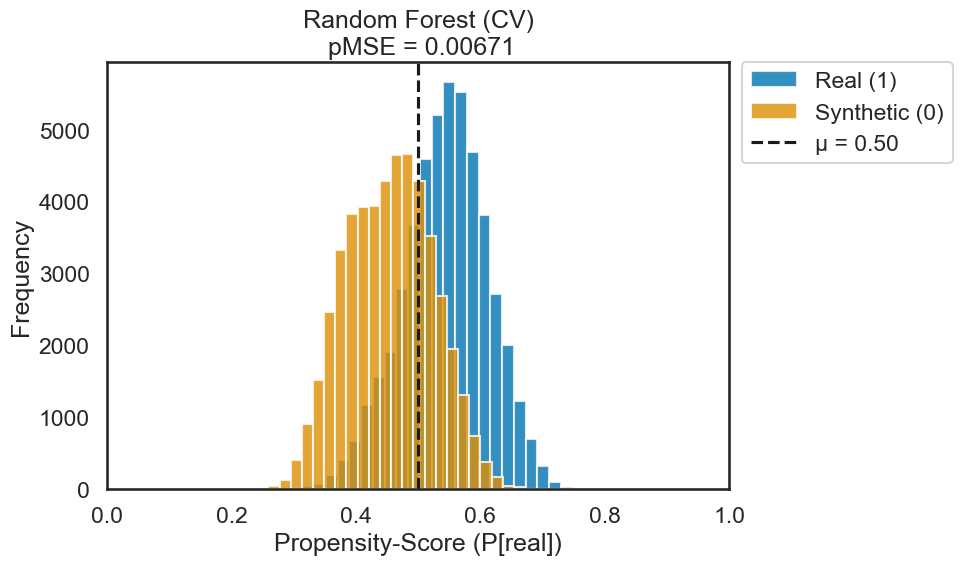

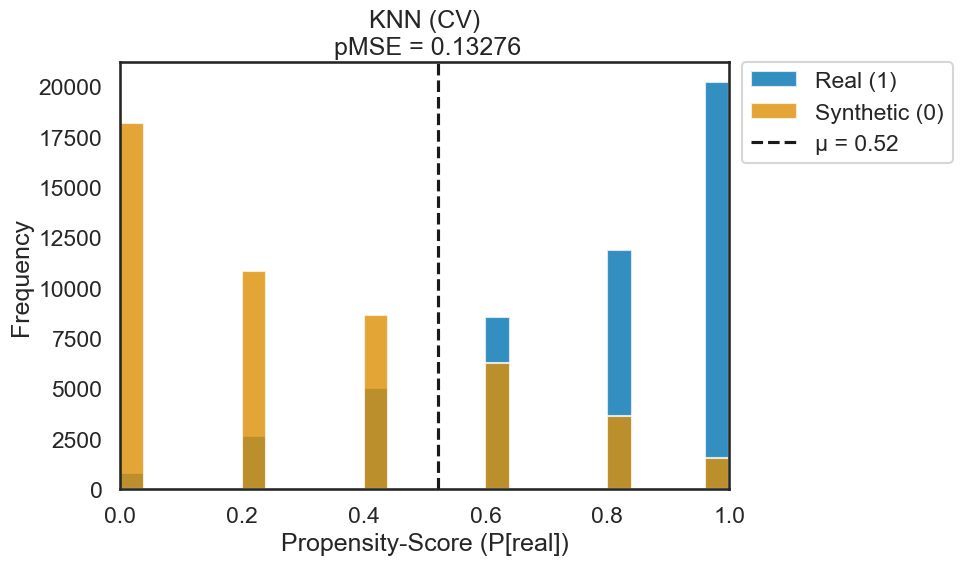

,pMSE_overall,fold_1,fold_2,fold_3,fold_4,fold_5
Model,,,,,,
Logistic Regression,0.040729,0.040929,0.040650,0.041233,0.040015,0.040806
Random Forest,0.006705,0.006747,0.006602,0.006757,0.006861,0.006556
KNN,0.132758,0.132151,0.133295,0.132640,0.132814,0.132846


In [16]:
# Laufzeit mit _sub 1s, mit allen: ~7 Min
data_all = df if SAMPLING_SIZE is None else df_combined

summary = pmse_final(data_all, labels=['Real', 'Synthetic'], cv=5, save_figures=SAVE_DATA, figsize = (10, 6),
                          model_names=['Logistic Regression', 'Random Forest', 'KNN'])

display(summary)

if SAVE_DATA:
    current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    summary.to_csv(
        f'results/pmse_data_{current_timestamp}.csv',
        index=True, sep=';', decimal=',', encoding='utf-8'
    )